In [1]:
import torch
from binNF.normalizing_flows.manager import *
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import torch.multiprocessing as mp
from mpl_toolkits.mplot3d import Axes3D
import vegas
import time
import datetime

In [2]:
def step(x):
    a=torch.zeros_like(x[:,0])
    b=torch.ones_like(x[:,0])
   
    return torch.where(torch.max(abs(x[:,0]), abs(x[:,1]))>1,a,b)

def g(x): #box: expect 0.25 in dim2
   
    q=torch.max(torch.abs(x),dim=-1).values
  
    a=torch.zeros_like(q)
    b=torch.ones_like(q)
   
    return torch.where(q<0.5,a,b)

def gaussian(x):
    return torch.exp( -((x[:,0]-0.5)**2+(x[:,1]-0.5)**2)/(0.3**2)) 

def gaussiannp(x):
    return np.exp( -((x[:,0]-0.5)**2+(x[:,1]-0.5)**2)/(0.3**2))

def gaussianveg(x):
    return np.exp( -((x[0]-0.5)**2+(x[1]-0.5)**2)/(0.3**2))


def camelnp(x):
    return np.exp( -((x[:,0]-0.75)**2+(x[:,1]-0.75)**2)/(0.2**2))+np.exp( -((x[:,0]-0.25)**2+(x[:,1]-0.25)**2)/(0.2**2))

def camelveg(x):
    return np.exp( -((x[0]-0.75)**2+(x[1]-0.75)**2)/(0.2**2))+np.exp( -((x[0]-0.25)**2+(x[1]-0.25)**2)/(0.2**2))


def camel(x):
    return torch.exp( -((x[:,0]-0.75)**2+(x[:,1]-0.75)**2)/(0.2**2))+torch.exp( -((x[:,0]-0.25)**2+(x[:,1]-0.25)**2)/(0.2**2))

def gaussianb(x):
    return torch.exp( -(x)**2)[:,0]

def gaussianbnp(x):
    return np.exp( -((x[:,0]+1)**2+(x[:,1])**2) )



def con(x):
    y=torch.empty(x.shape[0])
    return y.fill_(5)

def sin(x):
    return 2+torch.sin(x[:,1])

def lin(x):
    return 0.2*x[:,0]+0.5

def sinnp(x):
    return 2+np.sin(x[:,1])

def tanp(r):
    return (1+((torch.tan((r-0.5)*np.pi))**2))*np.pi


def create_fun(gn, gw):
    
    if(gn==1):
        def f(x):
                return torch.sum(torch.exp(-(x-0.5)**2/(gw**2)),-1)
        return f
    
    if(gn==2):
        def f(x):
                return torch.sum(torch.exp(-(x-0.25)**2/(gw**2))+torch.exp(-(x-0.75)**2/(gw**2)),-1)
        return f
    
    if(gn==4):
        def f(x):
            shift=torch.ones_like(x)*0.25
            shift1=shift.clone()*3
            lim=int((shift.shape[1]/2))
            shift2=torch.cat((shift[:,:lim],shift1[:,lim:]),-1)
            shift3=torch.cat((shift1[:,:lim],shift[:,lim:]),-1)
            return torch.sum(torch.exp(-(x-shift)**2/(gw**2))+torch.exp(-(x-shift1)**2/(gw**2))+torch.exp(-(x-shift2)**2/(gw**2))+torch.exp(-(x-shift3)**2/(gw**2)),-1)
        return f
    
    if(gn==8):
        def f(x):
            shift=torch.ones_like(x)*0.25#000
            shift1=shift.clone()*3#111
            lim=int((shift.shape[1]/3))
            shift2=torch.cat((shift[:,:lim],shift1[:,lim:2*lim],shift[:,2*lim:]),-1) #010
            shift3=torch.cat((shift1[:,:lim],shift[:,lim:]),-1)#100
            shift4=torch.cat((shift1[:,:lim],shift1[:,lim:2*lim],shift[:,2*lim:]),-1) #110
            shift5=torch.cat((shift[:,:2*lim],shift1[:,2*lim:]),-1) #001
            shift6=torch.cat((shift1[:,:lim],shift[:,lim:2*lim],shift1[:,2*lim:]),-1) #101
            shift7=torch.cat((shift[:,:lim],shift1[:,lim:]),-1) #011
            return torch.sum(torch.exp(-(x-shift)**2/(gw**2))+torch.exp(-(x-shift1)**2/(gw**2))+torch.exp(-(x-shift2)**2/(gw**2))+torch.exp(-(x-shift3)**2/(gw**2))+torch.exp(-(x-shift4)**2/(gw**2))+torch.exp(-(x-shift5)**2/(gw**2))+torch.exp(-(x-shift6)**2/(gw**2))+torch.exp(-(x-shift7)**2/(gw**2)),-1)
        return fill_

In [3]:
n_flow = 2   # number of dimensions

 
# We define our NormalizingFlow object 
NF =  PWQuadManager(n_flow=n_flow)



In [4]:

#The model is created
NF.create_model(n_cells=2, n_bins=7, NN=[11,11,11,11,11],dev=torch.device("cpu")) 
optim = torch.optim.Adamax(NF._model.parameters(),lr=2e-3, weight_decay=5e-07) 




w = torch.empty(10, NF.n_flow)
torch.nn.init.uniform_(w)
XJ = NF.model(NF.format_input(w,dev=torch.device("cpu")))
X = (XJ[:, :-1])
print(X)


tensor([[0.2202, 0.4635],
        [0.4716, 0.6308],
        [0.1507, 0.9054],
        [0.1883, 0.0971],
        [0.4447, 0.8258],
        [0.7155, 0.5953],
        [0.5652, 0.3838],
        [0.4082, 0.7604],
        [0.1645, 0.1771],
        [0.4316, 0.5210]], grad_fn=<SliceBackward>)


In [5]:
start_time=datetime.datetime.utcnow()
history=NF._train_variance_forward_seq(camel,optim,"./logs/tmp/",80000,1000,0,True, True,True)
end_time=datetime.datetime.utcnow()
print((end_time-start_time).total_seconds())

#CLEAN UP AND GIT
#FULL TEST 32
#CHECK BOUNDARY
#SEND OUT CALCULATION




44.812678


In [6]:

print('Initial loss')
print(NF.int_loss)
print('Epoch of best result')
print(NF.best_epoch)
print('Best loss')
print(NF.best_loss)
print('Best loss relative')
print(NF.best_loss_rel)
print('Function evaluations')
print(NF.best_func_count)
print('loss_estimator_var')
print(NF.best_var) 
w = torch.empty(10000, NF.n_flow)
torch.nn.init.uniform_(w)



Initial loss
tensor(0.1236)
Epoch of best result
45
Best loss
tensor(0.0796, grad_fn=<MeanBackward0>)
Best loss relative
tensor(0.6442, grad_fn=<DivBackward0>)
Function evaluations
3760000
loss_estimator_var
tensor(3.5953e-07, grad_fn=<DivBackward0>)


'\nif(m[0]==\'1\'):\n    XJ = m[1](NF.format_input(w,dev=torch.device("cpu")))\n    X = (XJ[:, :-1])\n    print(X)\n'

In [11]:

w = torch.empty(40, NF.n_flow)
torch.nn.init.uniform_(w)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w,torch.device("cpu")))

#print("mapped")
#print(NF.format_input(100*torch.tan((w-0.5)*(np.pi))))
XJ=NF.model(NF.format_input(w,torch.device("cpu")))


                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian

XJ2=NF.best_model(NF.format_input(w,torch.device("cpu")))


                    # Separate the points and their Jacobians:
print("XJ2")
print(XJ2)

"""
f=gaussian
print("f(x)")
print(f(X))


print("fXJ")
print(torch.mul(f(X), XJ[:, -1]))

print("loss without jac")
print(torch.mean(f(X)**2))

print("squared mean")
print(torch.mean(f(X))**2)

print("loss")
print(torch.mean(torch.mul(f(X), XJ[:, -1])**2))

"""

W
tensor([[0.8735, 0.8214],
        [0.3355, 0.7534],
        [0.3476, 0.9583],
        [0.6777, 0.0925],
        [0.5267, 0.8377],
        [0.0271, 0.6551],
        [0.2251, 0.5799],
        [0.8015, 0.2300],
        [0.6072, 0.7349],
        [0.7512, 0.8764],
        [0.7042, 0.7676],
        [0.1980, 0.8055],
        [0.2014, 0.2365],
        [0.1202, 0.4900],
        [0.5486, 0.8155],
        [0.2920, 0.0696],
        [0.2912, 0.3334],
        [0.2302, 0.3249],
        [0.1362, 0.2848],
        [0.0941, 0.2388],
        [0.5034, 0.8582],
        [0.4246, 0.2707],
        [0.7441, 0.9688],
        [0.3914, 0.8287],
        [0.7314, 0.9466],
        [0.3634, 0.6738],
        [0.5428, 0.6822],
        [0.9415, 0.6112],
        [0.9460, 0.2324],
        [0.8106, 0.2091],
        [0.9338, 0.6363],
        [0.6436, 0.8144],
        [0.9323, 0.7901],
        [0.3414, 0.5618],
        [0.8846, 0.1560],
        [0.5221, 0.2339],
        [0.4105, 0.2649],
        [0.7066, 0.6571],
        [0

'\nf=gaussian\nprint("f(x)")\nprint(f(X))\n\n\nprint("fXJ")\nprint(torch.mul(f(X), XJ[:, -1]))\n\nprint("loss without jac")\nprint(torch.mean(f(X)**2))\n\nprint("squared mean")\nprint(torch.mean(f(X))**2)\n\nprint("loss")\nprint(torch.mean(torch.mul(f(X), XJ[:, -1])**2))\n\n'

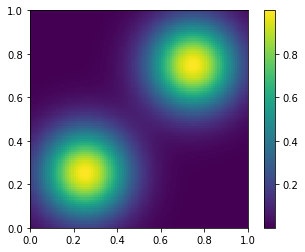

In [81]:
xs = np.linspace(-0,1,100)
ys = np.linspace(1,0,100) # in images the y axis is inverted
Xs,Ys = np.meshgrid(xs,ys)
zs=camelnp(np.array(list(zip(Xs.reshape(100*100),Ys.reshape(100*100)))).astype(np.float32)).reshape(100,100)

plt.imshow(zs, extent=[0,1,0,1])

plt.colorbar()
plt.show()

In [22]:
print("reset")
NF.create_model(n_pass_through=1,n_cells=1,n_bins=10, nn_width=2, NN=[20,20,20], roll_step=0)

w = torch.empty(10000, NF.n_flow, requires_grad=True)
torch.nn.init.uniform_(w,0,1)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w))
XJ = NF.model(NF.format_input(w))

                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian
X = ((XJ[:, :-1]).detach())
print("X")
print(X)
print("diff")
print(X[:,0]-w[:,1])
print("f(x)")
print(sin(X))

print("fXJ")
print(torch.mul(sin(X), XJ[:, -1]))

reset
W
tensor([[0.6108, 0.7451],
        [0.3028, 0.2412],
        [0.2823, 0.1151],
        ...,
        [0.5725, 0.1838],
        [0.8225, 0.9309],
        [0.1988, 0.2423]], requires_grad=True)
with jacob
tensor([[0.6108, 0.7451, 1.0000],
        [0.3028, 0.2412, 1.0000],
        [0.2823, 0.1151, 1.0000],
        ...,
        [0.5725, 0.1838, 1.0000],
        [0.8225, 0.9309, 1.0000],
        [0.1988, 0.2423, 1.0000]], grad_fn=<CatBackward>)
XJ
tensor([[0.6108, 0.7238, 0.7407],
        [0.3028, 0.2571, 1.1249],
        [0.2823, 0.1301, 1.1378],
        ...,
        [0.5725, 0.1827, 1.4329],
        [0.8225, 0.9263, 1.0666],
        [0.1988, 0.2883, 0.6346]], grad_fn=<CatBackward>)
X
tensor([[0.6108, 0.7238],
        [0.3028, 0.2571],
        [0.2823, 0.1301],
        ...,
        [0.5725, 0.1827],
        [0.8225, 0.9263],
        [0.1988, 0.2883]])
diff
tensor([-0.1342,  0.0616,  0.1672,  ...,  0.3886, -0.1084, -0.0435],
       grad_fn=<SubBackward0>)
f(x)
tensor([2.6622, 2.2543, 

In [ ]:
"""
#a4=fig.add_subplot(143)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax.title.set_text('Jacobian after training')
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


NF.create_model(n_pass_through=1,n_cells=1, nn_width=2, NN=[5], roll_step=1)
rcParams['axes.labelpad'] = 800
z = torch.empty((10000,2)) 
torch.nn.init.uniform_(z,0,1)

w=NF.format_input(z)
X=NF.model(w).data.numpy()
fig = plt.figure()
ax1 = fig.add_subplot(211, projection='3d')
ax1.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax1.title.set_text('Jacobian before training')
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)
#ax1.auto_scale_xyz([0.5, 2], [0, 1], [1.55, 1.75])
ax1.xaxis._axinfo['label']['space_factor'] = 4.8
ax1.zaxis._axinfo['label']['space_factor'] = 8.8
rcParams['axes.labelpad'] = 80

print("\n")
"""

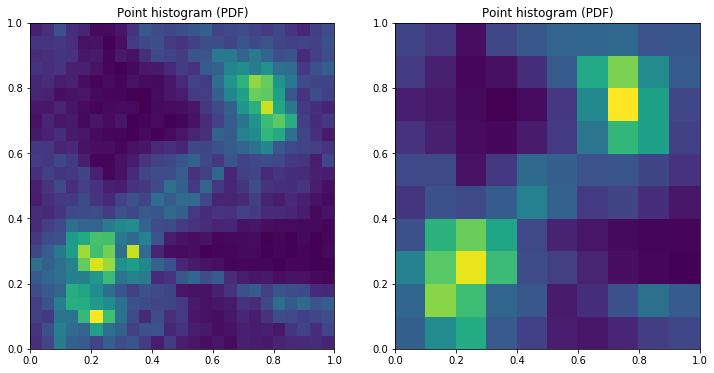

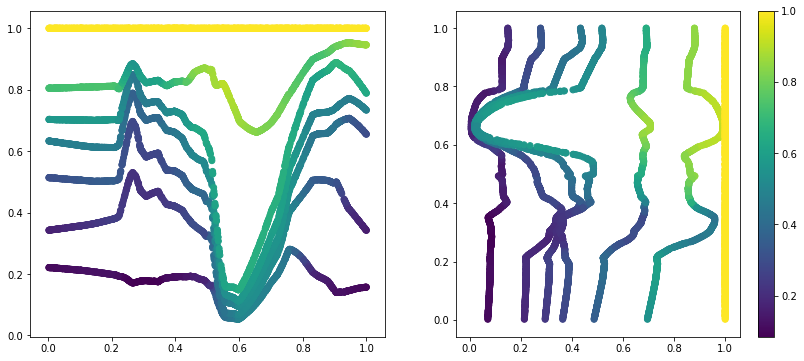

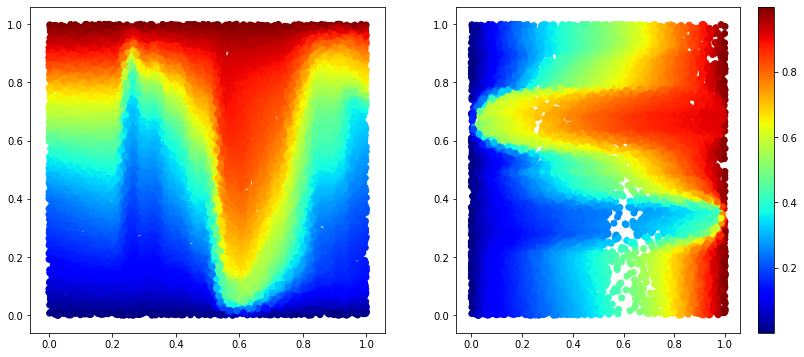

In [7]:
w = torch.empty((20000,2)) 
torch.nn.init.uniform_(w,0,1)
#q = torch.empty((12100,2)) 
#torch.nn.init.normal_(q,std=10)
#z=150*torch.tan((w-0.5)*(np.pi))
#model=torch.load('/home/niklas/Desktop/Thesis_code/Storage_runs/0905_run_camel_pwquad_2/1222/torch',map_location=torch.device('cpu'))
#NF.best_model.load_state_dict(model['model_state_dict'])
model=NF.best_model
Y=NF.format_input(w, dev=torch.device("cpu"))
X=NF.model(Y)
XZ=NF.best_model(Y)
#Z=(torch.atan(X)/np.pi+0.5).data.numpy()
#print(Z)
X=X.data.numpy()
XX=XZ.data.numpy()
#z=z.data.numpy()
#a3=fig.add_subplot(133)
fig = plt.figure(figsize=(12, 6))
a3=fig.add_subplot(121)

plt.hist2d(XX[:,0],XX[:,1],bins=25)
axes = plt.gca()
axes.set_xlim([-0,1]) 
axes.set_ylim([-0,1])
#a3.set_aspect(aspect=1.)


a3.title.set_text('Point histogram (PDF)')
a3.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


#fig = plt.figure(figsize=(6, 6))
a4=fig.add_subplot(122)

plt.hist2d(XX[:,0],XX[:,1],bins=10)
axes = plt.gca()
axes.set_xlim([-0,1])
axes.set_ylim([-0,1])
#a3.set_aspect(aspect=1.)


a4.title.set_text('Point histogram (PDF)')
a4.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)

f=camel

fig = plt.figure(figsize=(14, 6))
a5=fig.add_subplot(121)



w = torch.empty((1000,2)) 
torch.nn.init.uniform_(w,0,1)
for idx, m in enumerate(NF.model.named_children()):
        if(m[0]=='0'):
            Z=m[1].NN(w[:,:1])
            
            W=Z[:,:,m[1].n_bins+1:]
           
            W=torch.exp(W)
        
            Wsum = torch.cumsum(W, axis=-1) 
        
            Wnorms = torch.unsqueeze(Wsum[:, :, -1], axis=-1) 
            #print(w)
            
            W = W/Wnorms
            Wsum=Wsum/Wnorms
            V=Z[:,:,:m[1].n_bins+1]
            V=torch.exp(V)
        
            Vsum=torch.cumsum(V, axis=-1)


            Vnorms=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)

            Vnorms_tot=Vnorms[:, :, -1].clone() 
            V=torch.div(V,torch.unsqueeze(Vnorms_tot,axis=-1)) 
            VW=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)
            VW=torch.transpose(VW,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
           
            Wsum=torch.transpose(Wsum,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
            
            coords=np.stack([w[:,0].numpy() for 
                             _ in range(m[1].n_bins)], axis=0).reshape(w.shape[0]*m[1].n_bins,-1)
            
                
            
            
            plt.scatter(coords,torch.squeeze(Wsum,-1).detach().numpy(),c=torch.squeeze(VW,-1).detach().numpy())
            
            w2=m[1](NF.format_input(w,torch.device("cpu")))
      
        
        if(m[0]=='1'):
            a6=fig.add_subplot(122)
            
        
            Z=m[1].NN(torch.unsqueeze(w2[:,1],-1))
            
            W=Z[:,:,m[1].n_bins+1:]
            W=torch.exp(W)
            w2=w2.detach()
            Wsum = torch.cumsum(W, axis=-1) 
        
            Wnorms = torch.unsqueeze(Wsum[:, :, -1], axis=-1) 
            
            
            W = W/Wnorms
            Wsum=Wsum/Wnorms
            
            Wsum=torch.transpose(Wsum,0,2).reshape(m[1].n_bins*w2.shape[0],1,-1)
            V=Z[:,:,:m[1].n_bins+1]
            V=torch.exp(V)
        
            Vsum=torch.cumsum(V, axis=-1)


            Vnorms=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)

            Vnorms_tot=Vnorms[:, :, -1].clone() 
            V=torch.div(V,torch.unsqueeze(Vnorms_tot,axis=-1)) 
            VW=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)
            VW=torch.transpose(VW,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
            coords=np.stack([w2[:,1].numpy() for _ in range(m[1].n_bins)], axis=0)  
            
            plt.scatter(torch.squeeze(Wsum,-1).detach().numpy(), coords, c=torch.squeeze(VW,-1).detach().numpy())

plt.colorbar()


fig = plt.figure(figsize=(14, 6))
a7=fig.add_subplot(121)

w = torch.empty((20000,2)) 
torch.nn.init.uniform_(w,0,1)
for idx, m in enumerate(NF.model.named_children()):
        if(m[0]=='0'):
            
           
            
            plt.scatter(torch.unsqueeze(w[:,0],-1).detach().numpy(),torch.unsqueeze(w[:,1],-1).detach().numpy(),
                                c=torch.unsqueeze(m[1](NF.format_input(w,torch.device("cpu")))[:,1],-1).detach().numpy(),cmap='jet')
            
            w2=m[1](NF.format_input(w,torch.device("cpu")))
            w2=torch.cat((torch.roll(w2[:, :-1], 1, dims=-1), w2[:, -1:]), axis=-1)
        
        if(m[0]=='1'):
            a8=fig.add_subplot(122)
            q=m[1](NF.format_input(w2,torch.device("cpu")))
            c=torch.cat((torch.roll(q[:, :-1], 1, dims=-1), q[:, -1:]), axis=-1)
        
            plt.scatter(torch.unsqueeze(w2[:,1],-1).detach().numpy(),torch.unsqueeze(w2[:,0],-1).detach().numpy(),
                                c=torch.unsqueeze(q[:,1],-1).detach().numpy(),cmap='jet')
plt.colorbar()


In [4]:
w = torch.empty(20, 2)
torch.nn.init.normal_(w, std=100)
w.device

device(type='cpu')

In [25]:
f=camel
w = torch.empty(80000, NF.n_flow)
torch.nn.init.uniform_(w)
XJ = NF.best_model(NF.format_input(w,dev=torch.device("cpu")))
X = (XJ[:, :-1])
fXJ = torch.mul(f(X), XJ[:, -1])
loss = torch.mean(fXJ**2)
print(loss)
#0.083+-0.004

tensor(0.0782, grad_fn=<MeanBackward0>)


0.12414802731793036
0.12414802731792958
0.1037110290354486
0.09837401846920288
0.09684466157193035
0.09638549198197635
0.09624354497820616
0.09619816043518459
0.09618257286660237
0.09617627557749199
0.09617296138199517


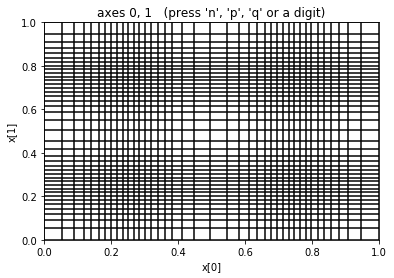

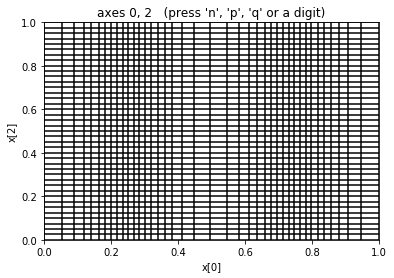

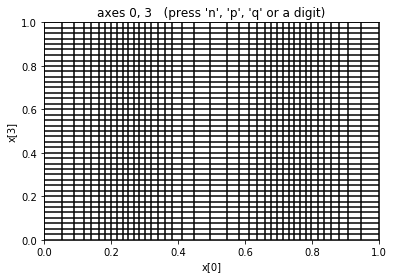

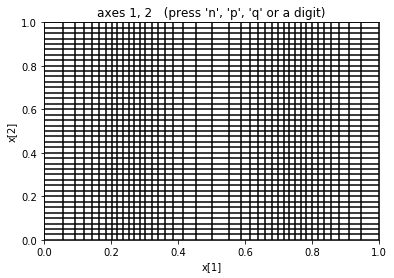

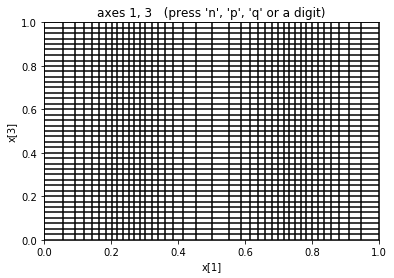

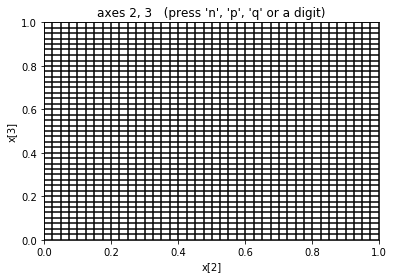

LOSSREL
0.7746454874910179
Time
2.740066
loss
0.09617070914274638


In [42]:
"""
integ = vegas.Integrator([[0, 1], [0, 1]])

result = integ(camelveg, nitn=10, neval=1000)
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))
"""
ngrid=40
f=create_funv(8,0.1)
#f=camelveg
start_time=datetime.datetime.utcnow()
m = vegas.AdaptiveMap([[0, 1]]*4, ninc=ngrid)


ny = np.int(30000*np.sqrt(2))
y = np.random.uniform(0., 1., (ny, 4))  # 300 000 random y's

x = np.empty(y.shape, float)            # work space
jac = np.empty(y.shape[0], float)
f2 = np.empty(y.shape[0], float)
loss_int=0
for j in range(ny): 
    loss_int+=f(y[j])**2/ny
print(loss_int)
#print('intial grid:')
#print(m.settings(ngrid))

for itn in range(10):                    # 10 iterations to adapt
    m.map(y, x, jac)                     # compute x's and jac
    loss=0
    for j in range(ny):                  # compute training data
        f2[j] = (jac[j] * f(x[j])) ** 2

    loss=np.mean(f2)
    print(loss)
    m.add_training_data(y, f2)           # adapt
    m.adapt(alpha=1)

    #print('iteration %d:' % itn)
    #print(m.settings(ngrid))
    

m.map(y, x, jac)                     # compute x's and jac
loss=0
for j in range(ny):                  # compute training data
    f2[j] = (jac[j] * f(x[j])) ** 2

loss=np.mean(f2)
end_time=datetime.datetime.utcnow()


m.show_grid(ngrid,[[0,1]])
#m.show_grid(ngrid, [[0,2]])
#m.show_grid(ngrid,[[0,3]])
#m.show_grid(ngrid,[[1,2]])
#m.show_grid(ngrid,[[1,3]])
#m.show_grid(ngrid,[[2,3]])
lossrel=loss/loss_int
print("LOSSREL")
print(lossrel)
print("Time")
print((end_time-start_time).total_seconds())
print("loss")
print(loss)

In [51]:
"""
LOSSREL
0.767648627612105
Time
22.754966
"""
print([[0,1]]*2)

[[0, 1], [0, 1]]


In [6]:
import torch
def get_bin(x, n=0):
    """
    Get the binary representation of x.

    Parameters
    ----------
    x : int
    n : int
        Minimum number of digits. If x needs less digits in binary, the rest
        is filled with zeros.

    Returns
    -------
    list of binary digits
    """
    y=format(x, 'b').zfill(n)
    return [int(i) for i in str(y)]
n_flow=16
dims=torch.arange(n_flow)
n=len(get_bin(n_flow-1,0))
dims_bin=torch.ones(n_flow,n)
dims_bin=map(get_bin, dims,[n]*n_flow)
q=torch.IntTensor(list(dims_bin))
print(q)
print(q[:,1])
r=q[:,1]
print((r == 1).nonzero())
np.floor(torch.FloatTensor(5/2))

tensor([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 1]], dtype=torch.int32)
tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1], dtype=torch.int32)
tensor([[ 4],
        [ 5],
        [ 6],
        [ 7],
        [12],
        [13],
        [14],
        [15]])


TypeError: new(): data must be a sequence (got float)

OSError: [Errno 12] Cannot allocate memory

0.8766801064611367
0.8766801064611357
0.6704843790855313
0.6089729502109095
0.5867682653223273
0.5778978552825914
0.574123968958074
0.5724410393543841
0.5716581179136015
0.571277730883637
0.5710839462897548


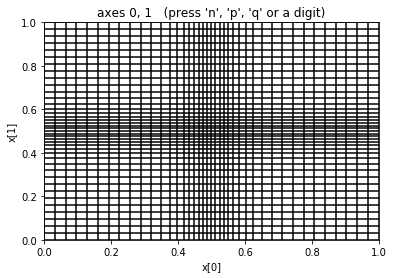

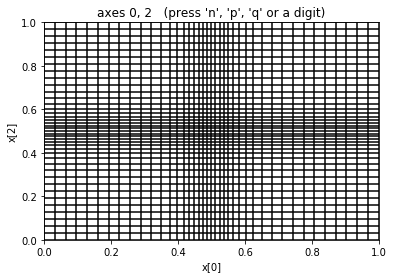

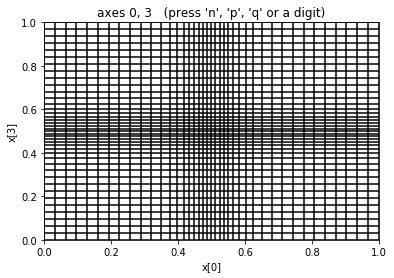

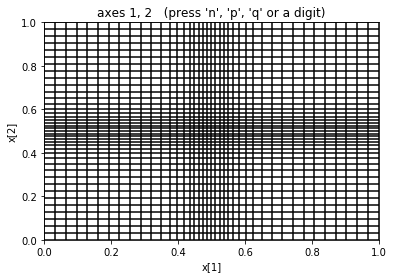

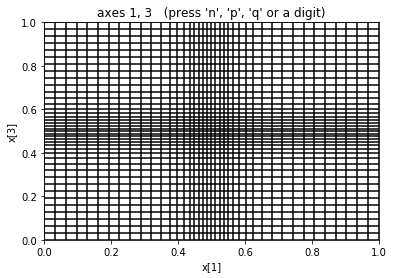

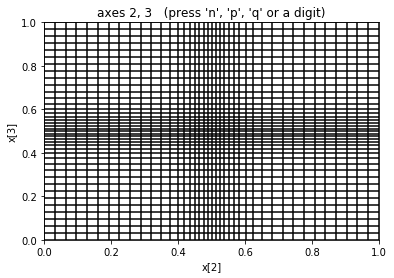

In [70]:
#test also dim=3
ngrid=40
f=create_funv(1,0.1)
#f=camelveg
start_time=datetime.datetime.utcnow()
m = vegas.AdaptiveMap([[0, 1]]*4, ninc=ngrid)

#m.show_grid(ngrid,axes=[[2,1],[0,2],[0,3],[1,2],[1,3],[2,3]])
#we gave NIS 3 000 000 evaluations -> 10 iterations * 300000 y's  ... 5 iterations till adaption
ny = np.int(30000*np.sqrt(2))
y = np.random.uniform(0., 1., (ny, 4))  # 300 000 random y's

x = np.empty(y.shape, float)            # work space
jac = np.empty(y.shape[0], float)
f2 = np.empty(y.shape[0], float)
loss_int=0
for j in range(ny): 
    loss_int+=f(y[j])**2/ny
print(loss_int)
#print('intial grid:')
#print(m.settings(ngrid))

for itn in range(10):                    # 10 iterations to adapt
    m.map(y, x, jac)                     # compute x's and jac
    loss=0
    for j in range(ny):                  # compute training data
        f2[j] = (jac[j] * f(x[j])) ** 2

    loss=np.mean(f2)
    print(loss)
    m.add_training_data(y, f2)           # adapt
    m.adapt(alpha=1)

    #print('iteration %d:' % itn)
    #print(m.settings(ngrid))
    

m.map(y, x, jac)                     # compute x's and jac
loss=0
for j in range(ny):                  # compute training data
    f2[j] = (jac[j] * f(x[j])) ** 2

loss=np.mean(f2)
end_time=datetime.datetime.utcnow()


m.show_grid(ngrid,[[0,1]])
m.show_grid(ngrid, [[0,2]])
m.show_grid(ngrid,[[0,3]])
m.show_grid(ngrid,[[1,2]])
m.show_grid(ngrid,[[1,3]])
m.show_grid(ngrid,[[2,3]])